In [1]:
import pandas as pd
import numpy as np
import json


In [2]:
df=pd.read_csv('chennai_cars - chennai_cars.csv.csv')
print(df.columns)

Index(['new_car_detail', 'new_car_overview', 'new_car_feature',
       'new_car_specs', 'car_links'],
      dtype='object')


In [3]:
print(df.head())

                                      new_car_detail  \
0  {'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...   
1  {'it': 0, 'ft': 'Petrol', 'bt': 'Minivans', 'k...   
2  {'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...   
3  {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   
4  {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   

                                    new_car_overview  \
0  {'heading': 'Car overview', 'top': [{'key': 'R...   
1  {'heading': 'Car overview', 'top': [{'key': 'R...   
2  {'heading': 'Car overview', 'top': [{'key': 'R...   
3  {'heading': 'Car overview', 'top': [{'key': 'R...   
4  {'heading': 'Car overview', 'top': [{'key': 'R...   

                                     new_car_feature  \
0  {'heading': 'Features', 'top': [{'value': 'Pow...   
1  {'heading': 'Features', 'top': [{'value': 'Low...   
2  {'heading': 'Features', 'top': [{'value': 'Pow...   
3  {'heading': 'Features', 'top': [{'value': 'Pow...   
4  {'heading': 'Features', 'top': [{'value': '

# importing the datasets, converting it from unstructered format to structered format and concatinating all the datsets to single datset

In [5]:
# Function to safely parse JSON strings
def safe_json_loads(json_str):
    if json_str is None:
        return {}  # Handle None case gracefully
    try:
        # Replace single quotes with double quotes and handle None
        json_str = json_str.replace("'", '"').replace('None', 'null')
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}  # Return an empty dict or handle as needed



In [6]:
# Function to process unstructured data
def process_city_data(data, city_name):
    structured_data = []
    
    for record in data:
        # Extract and parse the JSON strings safely
        detail = safe_json_loads(record.get('new_car_detail'))
        overview = safe_json_loads(record.get('new_car_overview'))
        features = safe_json_loads(record.get('new_car_feature'))
        specs = safe_json_loads(record.get('new_car_specs'))
        
        # Extract information from the parsed dictionaries
        city_info = {
            'model': detail.get('model'),
            'oem': detail.get('oem'),
            'modelYear': detail.get('modelYear'),
            'fuelType': detail.get('ft'),
            'bodyType': detail.get('bt'),
            'kmDriven': detail.get('km', '0').replace(',', ''),  # Handle None case
            'transmission': detail.get('transmission'),
            'ownerNo': detail.get('ownerNo'),
            'owner': detail.get('owner'),
            'price': detail.get('price'),
            'city': city_name,  # Add city name
            'trendingHeading': detail.get('trendingText', {}).get('heading'),
            'trendingDesc': detail.get('trendingText', {}).get('desc'),
            # Add other fields from overview, features, specs as needed
        }
         # Expand overview data into separate columns
        for item in overview.get('top', []):
            key = item['key'].lower().replace(' ', '_')  # Normalize key for column names
            city_info[key] = item['value']  # Add the value to city_info dict
            
        # Expand features data into separate columns
        for feature in features.get('top', []):
            feature_key = feature['value'].lower().replace(' ', '_').replace('&', 'and')  # Normalize key for column names
            city_info[feature_key] = True  # Add a boolean value indicating the feature is present
        # If there are more detailed specs in the 'data' section, extract those as well
        
        for category in specs.get('data', []):
            for spec in category.get('list', []):
                spec_key = spec['key'].lower().replace(' ', '_')  # Normalize key for column names
                city_info[spec_key] = spec['value']  # Add the value to city_info dict

        
        
        # Add additional details from overview, features, and specifications
        structured_data.append({**city_info, 
                                'overview': overview.get('top', []), 
                                'features': features.get('top', []), 
                                'specifications': specs.get('top', [])})

    return structured_data


In [7]:
# List of city CSV files
city_files = ['bangalore_cars - bangalore_cars.csv.csv', 
              'chennai_cars - chennai_cars.csv.csv', 
              'delhi_cars - delhi_cars.csv.csv', 
              'hyderabad_cars - hyderabad_cars.csv.csv', 
              'jaipur_cars - jaipur_cars.csv.csv', 
              'kolkata_cars - kolkata_cars.csv.csv']

# Dictionary to hold processed data for all cities
all_structured_data = []

In [8]:
for city_file in city_files:
    city_name = city_file.split('.')[0]  # Get the city name from the filename

    # Load the CSV file
    df = pd.read_csv(city_file)
    df.columns = df.columns.str.strip()  # Strip any whitespace from column names

    # Convert DataFrame to list of dictionaries
    city_data = df.to_dict(orient='records')

    # Process the data for the city
    processed_data = process_city_data(city_data, city_name)

    # Extend the main structured data list
    all_structured_data.extend(processed_data)

# Convert the structured data to a DataFrame
final_dataframe = pd.DataFrame(all_structured_data)

# Display the final structured DataFrame
print(final_dataframe.head())

                model      oem  modelYear fuelType   bodyType kmDriven  \
0      Maruti Celerio   Maruti       2015   Petrol  Hatchback   120000   
1       Ford Ecosport     Ford       2018   Petrol        SUV    32706   
2          Tata Tiago     Tata       2018   Petrol  Hatchback    11949   
3       Hyundai Xcent  Hyundai       2014   Petrol      Sedan    17794   
4  Maruti SX4 S Cross   Maruti       2015   Diesel        SUV    60000   

  transmission  ownerNo      owner        price  ... cruise_control  \
0       Manual        3  3rd Owner     ₹ 4 Lakh  ...            NaN   
1       Manual        2  2nd Owner  ₹ 8.11 Lakh  ...            NaN   
2       Manual        1  1st Owner  ₹ 5.85 Lakh  ...            NaN   
3       Manual        1  1st Owner  ₹ 4.62 Lakh  ...            NaN   
4       Manual        1  1st Owner  ₹ 7.90 Lakh  ...            NaN   

  drive_modes digital_clock passenger_air_bag rear_folding_table  \
0         NaN           NaN               NaN               

In [9]:
final_dataframe.drop(columns=['overview','features','specifications'],inplace=True)

In [10]:
final_dataframe.head(2)

,model,oem,modelYear,fuelType,bodyType,kmDriven,transmission,ownerNo,owner,price,...,cruise_control,drive_modes,digital_clock,passenger_air_bag,rear_folding_table,driving_experience_control_eco,engine_immobilizer,rear_spoiler,alloy_wheels,leddrls
0,Maruti Celerio,Maruti,2015,Petrol,Hatchback,120000,Manual,3,3rd Owner,₹ 4 Lakh,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ford Ecosport,Ford,2018,Petrol,SUV,32706,Manual,2,2nd Owner,₹ 8.11 Lakh,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
final_dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Columns: 132 entries, model to leddrls
dtypes: float64(3), int64(2), object(127)
memory usage: 8.4+ MB


In [12]:
final_dataframe.dtypes

model                             object
oem                               object
modelYear                          int64
fuelType                          object
bodyType                          object
                                   ...  
driving_experience_control_eco    object
engine_immobilizer                object
rear_spoiler                      object
alloy_wheels                      object
leddrls                           object
Length: 132, dtype: object

In [13]:
final_dataframe.describe()

,modelYear,ownerNo,year_of_manufacture,no_of_cylinder,values_per_cylinder
count,8369.000000,8369.000000,8349.000000,8338.000000,8318.000000
mean,2016.503286,1.360139,2016.547850,3.802471,3.934359
std,3.921465,0.641958,3.811882,0.594613,0.792698
min,1985.000000,0.000000,2002.000000,2.000000,2.000000
25%,2014.000000,1.000000,2014.000000,4.000000,4.000000
50%,2017.000000,1.000000,2017.000000,4.000000,4.000000
75%,2019.000000,2.000000,2019.000000,4.000000,4.000000
max,2023.000000,5.000000,2023.000000,23.000000,69.000000


In [14]:
final_dataframe.isnull().sum()

model                                0
oem                                  0
modelYear                            0
fuelType                             0
bodyType                             0
                                  ... 
driving_experience_control_eco    8368
engine_immobilizer                8368
rear_spoiler                      8368
alloy_wheels                      8367
leddrls                           8367
Length: 132, dtype: int64

In [15]:
print(final_dataframe['sun_roof'].value_counts())

sun_roof
True    1
Name: count, dtype: int64


In [16]:
# Identify identical columns using a try-except to handle unhashable types
identical_cols = []

for col in final_dataframe.columns:
    try:
        if final_dataframe[col].nunique() == 1:
            identical_cols.append(col)
    except TypeError:
        # Handle columns with unhashable types
        if final_dataframe[col].apply(lambda x: str(x)).nunique() == 1:
            identical_cols.append(col)

# Drop the identical columns if needed
final_dataframe = final_dataframe.drop(columns=identical_cols)

print("Identical columns:", identical_cols)

Identical columns: ['trendingHeading', 'trendingDesc', 'power_steering', 'power_windows_front', 'air_conditioner', 'heater', 'adjustable_head_lights', 'manually_adjustable_exterior_rear_view_mirror', 'centeral_locking', 'child_safety_locks', 'fog_lights_front', 'anti_lock_braking_system', 'cd_player', 'radio', 'power_adjustable_exterior_rear_view_mirror', 'brake_assist', 'electric_folding_rear_view_mirror', 'power_door_locks', 'cd_changer', 'fog_lights_rear', 'remote_trunk_opener', 'tinted_glass', 'halogen_headlamps', 'usb_auxiliary_input', 'passenger_side_rear_view_mirror', 'cassette_player', 'day_night_rear_view_mirror', 'power_windows_rear', 'leather_seats', 'leather_steering_wheel', 'rear_seat_belts', 'remote_fuel_lid_opener', 'bluetooth', 'speakers_front', 'power_antenna', 'dvd_player', 'audio_system_remote_control', 'wheel_covers', 'rear_window_wiper', 'driver_air_bag', 'low_fuel_warning_light', 'cup_holders_front', 'navigation_system', 'tachometer', 'glove_compartment', 'integra

In [17]:
num_columns = len(identical_cols)

print("Number of identical columns:", num_columns)

Number of identical columns: 77


In [18]:
final_dataframe.head(2)

,model,oem,modelYear,fuelType,bodyType,kmDriven,transmission,ownerNo,owner,price,...,turning_radius,front_brake_type,rear_brake_type,top_speed,acceleration,tyre_type,no_door_numbers,cargo_volumn,alloy_wheel_size,ground_clearance_unladen
0,Maruti Celerio,Maruti,2015,Petrol,Hatchback,120000,Manual,3,3rd Owner,₹ 4 Lakh,...,4.7 metres,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5,235-litres,NaN,NaN
1,Ford Ecosport,Ford,2018,Petrol,SUV,32706,Manual,2,2nd Owner,₹ 8.11 Lakh,...,5.3 metres,Ventilated Disc,Drum,NaN,NaN,"Tubeless,Radial",4,352-litres,16,NaN


In [19]:
i = 6000

# Set the option to display all columns
pd.set_option('display.max_columns', None)  # Show all columns

# Display the specified row
print(final_dataframe.iloc[i])

model                                   Maruti Ertiga
oem                                            Maruti
modelYear                                        2015
fuelType                                       Diesel
bodyType                                          MUV
kmDriven                                       120000
transmission                                   Manual
ownerNo                                             4
owner                                       4th Owner
price                                     ₹ 5.40 Lakh
city                        jaipur_cars - jaipur_cars
registration_year                                2015
insurance_validity              Third Party insurance
fuel_type                                      Diesel
seats                                         7 Seats
kms_driven                               1,20,000 Kms
rto                                               NaN
ownership                                Fourth Owner
engine_displacement         

In [20]:
def clean_column(dataframe, column_name, unit_removal_chars=None, conversion_type=float):
    if unit_removal_chars:
        # Remove specified characters (like 'Kg', 'Kms', 'Lakh', etc.)
        dataframe[column_name] = dataframe[column_name].replace(unit_removal_chars, '', regex=True)
    
    # Convert to numeric, handling errors by coercing invalid parsing to NaN
    dataframe[column_name] = pd.to_numeric(dataframe[column_name], errors='coerce')
    
    return dataframe

# List of columns to clean and convert
columns_to_clean = {
    'kmDriven': ['Kms'],  # Add any additional characters to remove
    'price': ['₹', ' Lakh'],  # Handle currency and unit
    'kms_driven': ['Kms'],  # Add any additional characters to remove
    'kerb_weight': ['Kg'],
    'gross_weight': ['Kg'],
    'top_speed': [' kmph'],
    'acceleration': [' Seconds'],
    'length': ['mm'],
    'width': ['mm'],
    'height': ['mm'],
    'wheel_base': ['mm'],
    'turning_radius': ['m'],
}

In [21]:
# Clean each specified column
for column, chars in columns_to_clean.items():
    final_dataframe = clean_column(final_dataframe, column, chars)

# Remove specified columns
final_dataframe.drop(columns=['owner', 'ownership', 'engine_displacement','kms_driven'], inplace=True)



In [22]:
# Clean 'registration_year' to retain only numeric values
final_dataframe['registration_year'] = final_dataframe['registration_year'].replace('[^0-9]', '', regex=True)
final_dataframe['registration_year'] = pd.to_numeric(final_dataframe['registration_year'], errors='coerce')

# Clean 'seats' to retain only numeric values
final_dataframe['seats'] = final_dataframe['seats'].replace('[^0-9]', '', regex=True)
final_dataframe['seats'] = pd.to_numeric(final_dataframe['seats'], errors='coerce')
final_dataframe['engine_type'] = final_dataframe['engine_type'].str.replace('Engine', '', regex=False, case=False)
final_dataframe['displacement'] = pd.to_numeric(final_dataframe['displacement'], errors='coerce')
final_dataframe['ground_clearance_unladen'] = final_dataframe['ground_clearance_unladen'].str.replace('mm', '', regex=False, case=False)
final_dataframe['cargo_volumn'] = final_dataframe['cargo_volumn'].replace('[^0-9]', '', regex=True)

In [23]:
# Update 'city' column based on specified patterns
city_mapping = {
    'bangalore_cars - bangalore_cars': 'bangalore',
    'delhi_cars - delhi_cars': 'delhi',
    'jaipur_cars - jaipur_cars': 'jaipur',
    'kolkata_cars - kolkata_cars': 'kolkata',
    'hyderabad_cars - hyderabad_cars': 'hyderabad',
    'chennai_cars - chennai_cars': 'chennai'
}
final_dataframe['city'] = final_dataframe['city'].replace(city_mapping)

In [24]:
i = 349

# Set the option to display all columns
pd.set_option('display.max_columns', None)  # Show all columns

# Display the specified row
print(final_dataframe.iloc[i])

model                            Volkswagen Vento
oem                                    Volkswagen
modelYear                                    2011
fuelType                                   Diesel
bodyType                                    Sedan
kmDriven                                    90000
transmission                               Manual
ownerNo                                         4
price                                        2.19
city                                    bangalore
registration_year                          2011.0
insurance_validity          Third Party insurance
fuel_type                                  Diesel
seats                                         5.0
rto                                          KL24
year_of_manufacture                        2011.0
color                                      Others
engine_type                   Common Rail Diesel 
displacement                               1598.0
max_power                        103.6bhp@4400rpm


In [25]:
# Dropping features with high missing values
final_dataframe.drop(columns=['gross_weight', 'compression_ratio', 'turning_radius', 'top_speed', 'borex_stroke', 'super_charger','fuel_type'], inplace=True)

In [26]:
# Impute missing values without using inplace=True
final_dataframe['price'] = final_dataframe['price'].fillna(final_dataframe['price'].mean())
final_dataframe['registration_year'] = final_dataframe['registration_year'].fillna(final_dataframe['registration_year'].mean())
final_dataframe['seats'] = final_dataframe['seats'].fillna(final_dataframe['seats'].mode()[0])
final_dataframe['length'] = final_dataframe['length'].fillna(final_dataframe['length'].mean())
final_dataframe['width'] = final_dataframe['width'].fillna(final_dataframe['width'].mean())
final_dataframe['height'] = final_dataframe['height'].fillna(final_dataframe['height'].mean())
final_dataframe['wheel_base'] = final_dataframe['wheel_base'].fillna(final_dataframe['wheel_base'].mean())
final_dataframe['kerb_weight'] = final_dataframe['kerb_weight'].fillna(final_dataframe['kerb_weight'].mean())
final_dataframe['no_of_cylinder'] = final_dataframe['no_of_cylinder'].fillna(final_dataframe['no_of_cylinder'].mode()[0])
final_dataframe['values_per_cylinder'] = final_dataframe['values_per_cylinder'].fillna(final_dataframe['values_per_cylinder'].mean())
final_dataframe['acceleration'] = final_dataframe['acceleration'].fillna(final_dataframe['acceleration'].mean())
final_dataframe['year_of_manufacture']=final_dataframe['year_of_manufacture'].fillna(final_dataframe['year_of_manufacture'].mean())


# Imputing categorical columns
categorical_columns = ['insurance_validity','fuelType','color', 'engine_type', 'rto', 'gear_box', 'drive_type', 'seating_capacity', 'front_tread',
                       'rear_tread','value_configuration','fuel_suppy_system','turbo_charger','steering_type','front_brake_type','rear_brake_type',
                       'tyre_type','no_door_numbers','alloy_wheel_size','ground_clearance_unladen']

# For categorical columns with mode
for column in categorical_columns:
    final_dataframe[column] = final_dataframe[column].fillna(final_dataframe[column].mode()[0])

In [27]:
# Convert to integer after filling NaNs
final_dataframe['front_tread'] = final_dataframe['front_tread'].str.replace('mm', '', regex=False).str.replace('`', '', regex=False).str.replace(',', '', regex=False).astype(int)
final_dataframe['rear_tread'] = final_dataframe['rear_tread'].str.replace('mm', '', regex=False).str.replace('`', '', regex=False).str.replace(',', '', regex=False).astype(int)


In [28]:
final_dataframe[['max_power_bhp','max_power_rpm']] = final_dataframe['max_power'].str.extract(r'(\d+\.\d+)bhp@(\d+)rpm')
final_dataframe['max_power_bhp'] = pd.to_numeric(final_dataframe['max_power_bhp'])
final_dataframe['max_power_rpm'] = pd.to_numeric(final_dataframe['max_power_rpm'])
# Drop original column
final_dataframe.drop('max_power', axis=1, inplace=True)

In [29]:
final_dataframe[['max_torque_nm', 'min_torque_rpm', 'max_torque_rpm']] = final_dataframe['max_torque'].str.extract(r'(\d+)Nm@(\d+)-(\d+)rpm')
final_dataframe['max_torque_nm'] = pd.to_numeric(final_dataframe['max_torque_nm'])
final_dataframe['min_torque_rpm'] = pd.to_numeric(final_dataframe['min_torque_rpm'])
final_dataframe['max_torque_rpm'] = pd.to_numeric(final_dataframe['max_torque_rpm'])

In [30]:
i = 20

# Set the option to display all columns
pd.set_option('display.max_columns', None)  # Show all columns

# Display the specified row
print(final_dataframe.iloc[i])

model                                       BMW 5 Series
oem                                                  BMW
modelYear                                           2011
fuelType                                          Diesel
bodyType                                           Sedan
kmDriven                                          100000
transmission                                   Automatic
ownerNo                                                3
price                                               22.0
city                                           bangalore
registration_year                                 2011.0
insurance_validity                 Third Party insurance
seats                                                5.0
rto                                                 WB02
year_of_manufacture                               2011.0
color                                              White
engine_type                                     In-Line 
displacement                   

In [31]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   model                     8369 non-null   object 
 1   oem                       8369 non-null   object 
 2   modelYear                 8369 non-null   int64  
 3   fuelType                  8369 non-null   object 
 4   bodyType                  8369 non-null   object 
 5   kmDriven                  8369 non-null   int64  
 6   transmission              8369 non-null   object 
 7   ownerNo                   8369 non-null   int64  
 8   price                     8369 non-null   float64
 9   city                      8369 non-null   object 
 10  registration_year         8369 non-null   float64
 11  insurance_validity        8369 non-null   object 
 12  seats                     8369 non-null   float64
 13  rto                       8369 non-null   object 
 14  year_of_

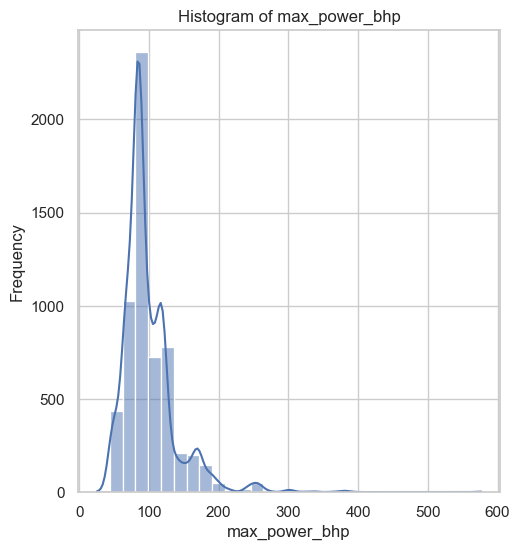

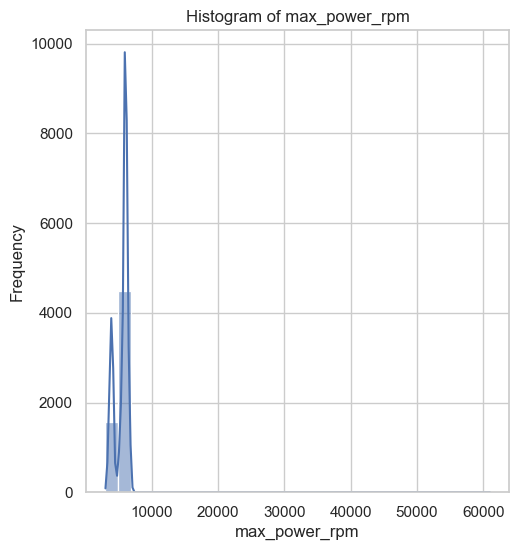

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')

# Columns to visualize
columns_to_check = ['max_power_bhp', 'max_power_rpm']

# Loop through the columns to create histograms and box plots
for column in columns_to_check:
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(final_dataframe[column], bins=30, kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

   

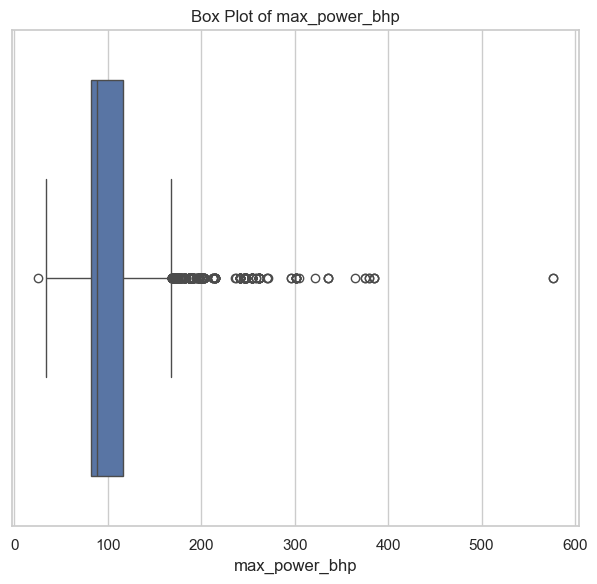

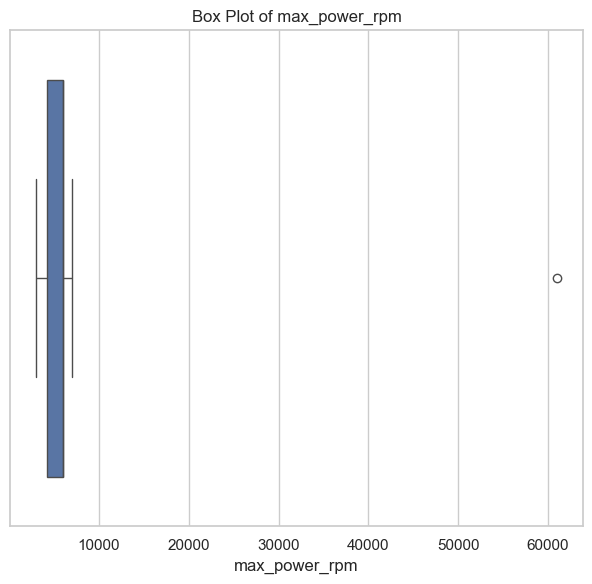

In [33]:
 for column in columns_to_check:
    plt.figure(figsize=(12, 6))
# Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=final_dataframe[column])
    plt.title(f'Box Plot of {column}')

    plt.tight_layout()
    plt.show()

In [34]:
final_dataframe['max_power_bhp'] = final_dataframe['max_power_bhp'].fillna(final_dataframe['max_power_bhp'].median())
final_dataframe['max_power_rpm'] = final_dataframe['max_power_rpm'].fillna(final_dataframe['max_power_rpm'].median())

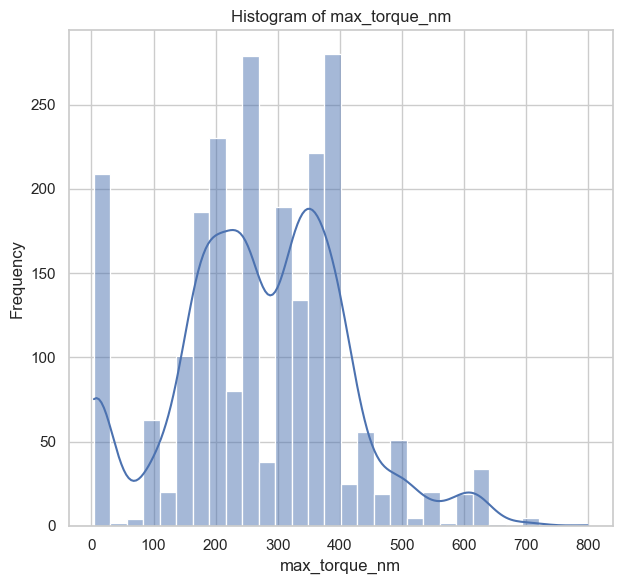

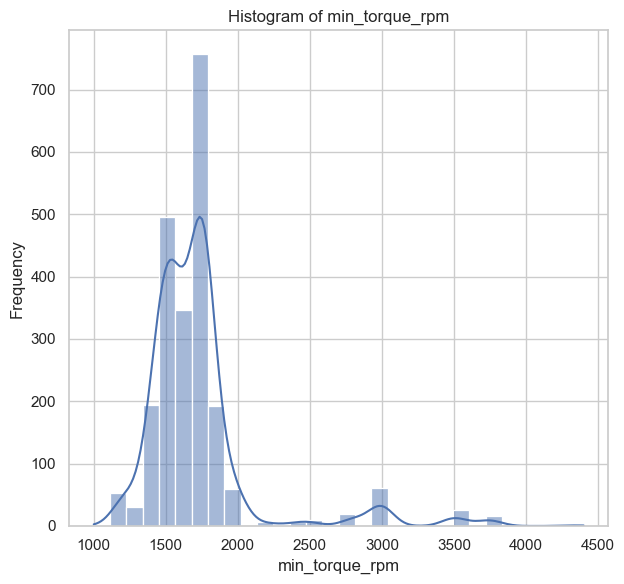

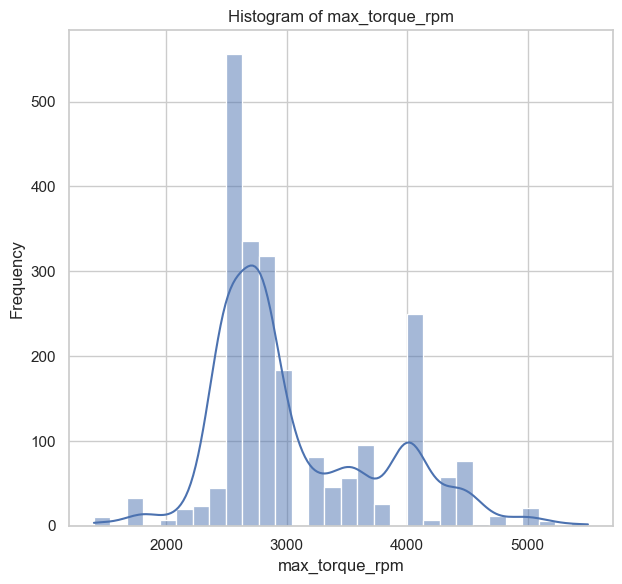

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Set the aesthetic style of the plots
sns.set(style='whitegrid')

# Example column names
columns_to_check = ['max_torque_nm', 'min_torque_rpm', 'max_torque_rpm']

for column in columns_to_check:
    # Histogram
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(final_dataframe[column], bins=30, kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

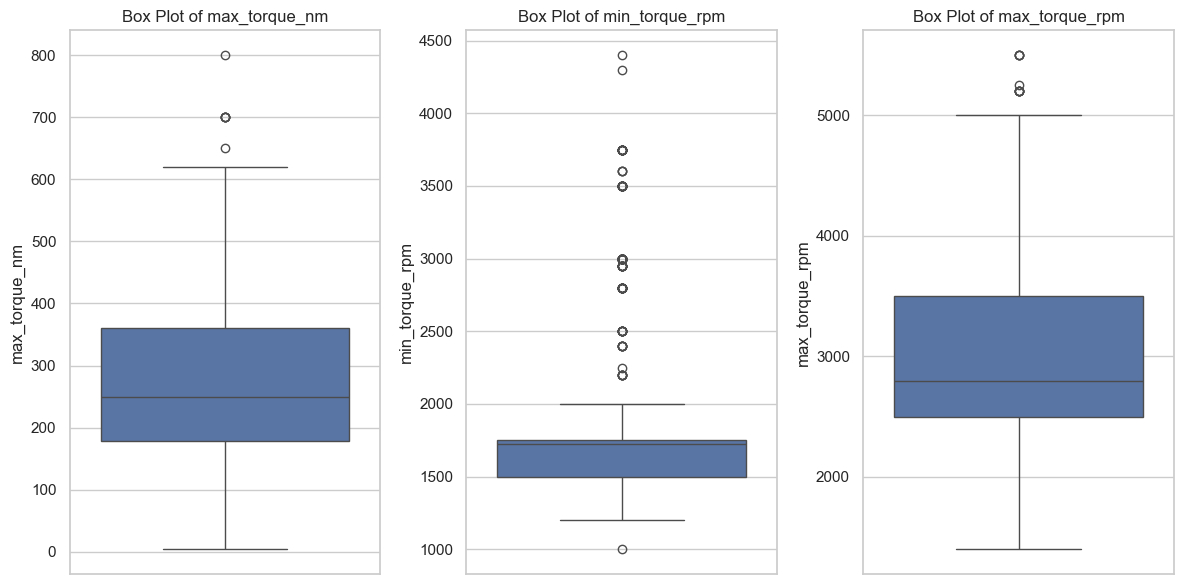

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style='whitegrid')

# Example column names
columns_to_check = ['max_torque_nm', 'min_torque_rpm', 'max_torque_rpm']

# Create box plots for each column
plt.figure(figsize=(12, 6))

for i, column in enumerate(columns_to_check, 1):
    plt.subplot(1, 3, i)  # Adjust subplot arrangement as needed
    sns.boxplot(y=final_dataframe[column])
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [37]:
final_dataframe['max_torque_nm'] = final_dataframe['max_torque_nm'].fillna(final_dataframe['max_torque_nm'].median())
final_dataframe['min_torque_rpm'] = final_dataframe['min_torque_rpm'].fillna(final_dataframe['min_torque_rpm'].median())
final_dataframe['max_torque_rpm'] = final_dataframe['max_torque_rpm'].fillna(final_dataframe['max_torque_rpm'].median())

In [38]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   model                     8369 non-null   object 
 1   oem                       8369 non-null   object 
 2   modelYear                 8369 non-null   int64  
 3   fuelType                  8369 non-null   object 
 4   bodyType                  8369 non-null   object 
 5   kmDriven                  8369 non-null   int64  
 6   transmission              8369 non-null   object 
 7   ownerNo                   8369 non-null   int64  
 8   price                     8369 non-null   float64
 9   city                      8369 non-null   object 
 10  registration_year         8369 non-null   float64
 11  insurance_validity        8369 non-null   object 
 12  seats                     8369 non-null   float64
 13  rto                       8369 non-null   object 
 14  year_of_

In [39]:
cargo_volumn_data = pd.to_numeric(final_dataframe['cargo_volumn'], errors='coerce')
Q1 = cargo_volumn_data.quantile(0.25)
Q3 = cargo_volumn_data.quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Display the results
print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")

Q1: 268.0
Q3: 460.0
IQR: 192.0


In [40]:
# Convert to numeric, coercing errors to NaN
final_dataframe['cargo_volumn'] = pd.to_numeric(final_dataframe['cargo_volumn'], errors='coerce')

# Fill missing values with the median
median_cargo_volume = final_dataframe['cargo_volumn'].median()
final_dataframe['cargo_volumn']=final_dataframe['cargo_volumn'].fillna(median_cargo_volume)


In [41]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   model                     8369 non-null   object 
 1   oem                       8369 non-null   object 
 2   modelYear                 8369 non-null   int64  
 3   fuelType                  8369 non-null   object 
 4   bodyType                  8369 non-null   object 
 5   kmDriven                  8369 non-null   int64  
 6   transmission              8369 non-null   object 
 7   ownerNo                   8369 non-null   int64  
 8   price                     8369 non-null   float64
 9   city                      8369 non-null   object 
 10  registration_year         8369 non-null   float64
 11  insurance_validity        8369 non-null   object 
 12  seats                     8369 non-null   float64
 13  rto                       8369 non-null   object 
 14  year_of_

In [42]:
from sklearn.preprocessing import LabelEncoder
# Identify categorical columns
nominal_columns = ['model', 'oem', 'fuelType', 'bodyType', 'transmission', 
                   'city', 'insurance_validity', 'rto', 
                   'color', 'engine_type', 'value_configuration', 
                   'fuel_suppy_system', 'turbo_charger', 'gear_box', 
                   'drive_type', 'seating_capacity', 'steering_type', 
                   'front_brake_type', 'rear_brake_type', 'tyre_type','ground_clearance_unladen']
ordinal_columns = ['no_door_numbers','alloy_wheel_size',]  # Add any ordinal columns if applicable

# One-hot encoding for nominal variables
final_dataframe = pd.get_dummies(final_dataframe, columns=nominal_columns, drop_first=True)

# Label encoding for ordinal variables
label_encoders = {}
for column in ordinal_columns:
    le = LabelEncoder()
    final_dataframe[column] = le.fit_transform(final_dataframe[column])
    label_encoders[column] = le

# Display the modified DataFrame
print(final_dataframe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Columns: 1890 entries, modelYear to ground_clearance_unladen_91
dtypes: bool(1863), float64(19), int32(4), int64(3), object(1)
memory usage: 16.5+ MB
None


In [43]:
final_dataframe.head()

modelYear  kmDriven  ownerNo  price  registration_year  seats  \
0       2015    120000        3   4.00             2015.0    5.0   
1       2018     32706        2   8.11             2018.0    5.0   
2       2018     11949        1   5.85             2018.0    5.0   
3       2014     17794        1   4.62             2014.0    5.0   
4       2015     60000        1   7.90             2015.0    5.0   

   year_of_manufacture  displacement        max_torque  no_of_cylinder  \
0               2015.0         998.0      90Nm@3500rpm             3.0   
1               2018.0        1497.0     150Nm@4500rpm             3.0   
2               2018.0        1199.0     114Nm@3500rpm             3.0   
3               2014.0        1197.0  113.75Nm@4000rpm             4.0   
4               2015.0        1248.0     200Nm@1750rpm             4.0   

   values_per_cylinder  length   width  height  wheel_base  front_tread  \
0                  4.0  3715.0  1635.0  1565.0      2425.0         1420   
1                  4.0  3998.0  1765.0  1647.0      2519.0         1295   
2                  4.0  3746.0  1647.0  1535.0      2400.0         1400   
3                  4.0  3995.0  1660.0  1520.0      2425.0         1479   
4                  4.0  4300.0  1785.0  1595.0      2600.0         1295   

   rear_tread  kerb_weight  acceleration  no_door_numbers  cargo_volumn  \
0        1410  1251.620277     15.050000                3         235.0   
1        1290  1242.000000     12.809558                2         352.0   
2        1420  1251.620277     14.300000                3         242.0   
3        1493  1180.000000     14.200000                2         407.0   
4        1290  1230.000000     12.000000                3         353.0   

   alloy_wheel_size  max_power_bhp  max_power_rpm  max_torque_nm  \
0                 4          67.04         6000.0          250.0   
1                 4         121.31         6500.0          250.0   
2                 2          88.50         6000.0          250.0   
3                 2          81.86         6000.0          250.0   
4                 4          88.50         4000.0          250.0   

   min_torque_rpm  max_torque_rpm  model_Audi A3  model_Audi A3 cabriolet  \
0          1725.0          2800.0          False                    False   
1          1725.0          2800.0          False                    False   
2          1725.0          2800.0          False                    False   
3          1725.0          2800.0          False                    False   
4          1725.0          2800.0          False                    False   

   model_Audi A4  model_Audi A6  model_Audi A8  model_Audi Q2  model_Audi Q3  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False          False          False   
4          False          False          False          False          False   

   model_Audi Q3 Sportback  model_Audi Q5  model_Audi Q7  \
0                    False          False          False   
1                    False          False          False   
2                    False          False          False   
3                    False          False          False   
4                    False          False          False   

   model_Audi S5 Sportback  model_BMW 1 Series  model_BMW 2 Series  \
0                    False               False               False   
1                    False               False               False   
2                    False               False               False   
3                    False               False               False   
4                    False               False               False   

   model_BMW 3 Series  model_BMW 3 Series GT  \
0               False                  False   
1               

In [44]:
## Performing min_max scalling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
numerical_features = ['modelYear', 'kmDriven', 'ownerNo', 'price', 'registration_year','seats', 'displacement','year_of_manufacture','no_of_cylinder','values_per_cylinder',
                      'length','width', 'height','wheel_base', 'front_tread', 'rear_tread', 'kerb_weight','acceleration', 'cargo_volumn','max_power_bhp','max_power_rpm',
                     'max_torque_nm','min_torque_rpm','max_torque_rpm']

In [45]:
numerical_columns = final_dataframe.select_dtypes(include=['float64', 'int64']).columns

# Standard Scaling: Scales features to have mean 0 and standard deviation 1
scaler = StandardScaler()
final_dataframe[numerical_columns] = scaler.fit_transform(final_dataframe[numerical_columns])

# Display the modified DataFrame info
print(final_dataframe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Columns: 1890 entries, modelYear to ground_clearance_unladen_91
dtypes: bool(1863), float64(22), int32(4), object(1)
memory usage: 16.5+ MB
None


In [46]:
# Assuming final_dataframe is your DataFrame
# Select only numeric columns
numeric_df = final_dataframe.select_dtypes(include=['number'])

# Calculate skewness and kurtosis
skewness = numeric_df.skew()
kurtosis = numeric_df.kurt()

# Combine results into a DataFrame
distribution_stats = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})

# Display features with extreme skewness or kurtosis
extreme_distribution = distribution_stats[(distribution_stats['Skewness'].abs() > 1) | (distribution_stats['Kurtosis'].abs() > 1)]
print(extreme_distribution)

                      Skewness     Kurtosis
modelYear            -0.911899     1.773371
kmDriven             50.392530  3548.131455
ownerNo               1.898179     4.368131
price                 3.685555    17.116328
seats                 2.590518     7.670713
displacement          1.615023     4.387557
no_of_cylinder        4.978941   136.572971
values_per_cylinder  66.307175  5493.029648
width                 0.795043     2.132153
height                1.205894     1.230034
wheel_base            1.077321     1.713921
front_tread           0.383992    -1.344788
rear_tread            0.403196    -1.314197
kerb_weight           1.273173     4.946379
acceleration          0.738505     7.976878
no_door_numbers      -1.137251     0.554772
cargo_volumn         22.792349   517.850049
alloy_wheel_size      2.349944     8.277751
max_power_bhp         3.325389    22.177175
max_power_rpm        16.652347   915.193399
max_torque_nm         0.733459     8.485256
min_torque_rpm        5.723691  

In [47]:
import pandas as pd

# Identify numerical columns (for outlier detection)
numerical_columns = final_dataframe.select_dtypes(include=['float64', 'int64']).columns

# List of columns to remove outliers for (extreme skewness and kurtosis)
columns_to_remove_outliers = ['kmDriven', 'price', 'no_of_cylinder', 'values_per_cylinder', 'cargo_volumn',
                              'max_power_rpm', 'min_torque_rpm']

# List of columns to cap outliers for (moderate skewness and kurtosis)
columns_to_cap_outliers = ['seats', 'displacement', 'height', 'wheel_base', 'kerb_weight', 'acceleration',
                           'alloy_wheel_size', 'max_power_bhp', 'max_torque_nm', 'modelYear', 'width',
                           'front_tread', 'rear_tread', 'no_door_numbers']

# Define a function to remove or cap outliers using IQR
def remove_outliers_iqr(df, columns_to_remove, columns_to_cap):
    for column in columns_to_remove:
        Q1 = df[column].quantile(0.25)  # 25th percentile
        Q3 = df[column].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile Range

        # Define the upper and lower bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers (values outside the bounds)
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    for column in columns_to_cap:
        Q1 = df[column].quantile(0.25)  # 25th percentile
        Q3 = df[column].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile Range

        # Define the upper and lower bounds for capping
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap outliers (values outside the bounds are set to the bounds)
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df

# Apply the IQR outlier removal and capping
final_dataframe = remove_outliers_iqr(final_dataframe, columns_to_remove_outliers, columns_to_cap_outliers)

# Display the modified DataFrame info
print(final_dataframe.info())


<class 'pandas.core.frame.DataFrame'>
Index: 4523 entries, 0 to 8367
Columns: 1890 entries, modelYear to ground_clearance_unladen_91
dtypes: bool(1863), float64(23), int32(3), object(1)
memory usage: 9.0+ MB
None


In [48]:
# Apply log transformation to skewed features
skewed_features = ['kmDriven', 'price', 'values_per_cylinder', 'max_power_rpm', 'max_torque_rpm']
for feature in skewed_features:
    final_dataframe[feature] = np.log1p(final_dataframe[feature])  # log1p handles log(0) safely

# Verify the skewness and kurtosis after transformation
skewness = final_dataframe[skewed_features].skew()
kurtosis = final_dataframe[skewed_features].kurt()

print("Skewness after transformation:")
print(skewness)
print("\nKurtosis after transformation:")
print(kurtosis)


Skewness after transformation:
kmDriven              -0.399113
price                 -0.046934
values_per_cylinder    0.000000
max_power_rpm         -1.755269
max_torque_rpm         0.000000
dtype: float64

Kurtosis after transformation:
kmDriven              -0.368891
price                 -0.130662
values_per_cylinder    0.000000
max_power_rpm          4.875592
max_torque_rpm         0.000000
dtype: float64


## EXPLORATORY DATA ANALYSIS

In [50]:
# Identify numerical columns (for descriptive statistics)
numerical_columns = final_dataframe.select_dtypes(include=['float64', 'int64']).columns

# Calculate summary statistics for only numerical columns
summary_stats = final_dataframe[numerical_columns].describe()

# Calculate additional statistics (mean, median, mode)
mean_values = final_dataframe[numerical_columns].mean()
median_values = final_dataframe[numerical_columns].median()
mode_values = final_dataframe[numerical_columns].mode().iloc[0]  # Mode returns a DataFrame, so we take the first row

# Displaying the statistics
print("Summary Statistics:\n", summary_stats)
print("\nMean Values:\n", mean_values)
print("\nMedian Values:\n", median_values)
print("\nMode Values:\n", mode_values)


Summary Statistics:
          modelYear     kmDriven      ownerNo        price  registration_year  \
count  4523.000000  4523.000000  4523.000000  4523.000000        4523.000000   
mean     -0.053049    -0.173650     0.010365    -0.526376          -0.065450   
std       0.989354     0.484178     0.987349     0.400395           1.034391   
min      -2.551058    -1.591309    -2.118860    -1.531116          -3.844536   
25%      -0.638393    -0.496340    -0.561033    -0.797154          -0.687342   
50%       0.126673    -0.129177    -0.561033    -0.509715           0.101956   
75%       0.636717     0.167481     0.996793    -0.258738           0.628155   
max       1.656805     0.831047     5.670272     0.578372           1.680553   

              seats  year_of_manufacture  displacement  no_of_cylinder  \
count  4.523000e+03          4523.000000   4523.000000     4523.000000   
mean  -3.061346e-01            -0.068500     -0.454144       -0.185443   
std    7.661386e-15             1.03

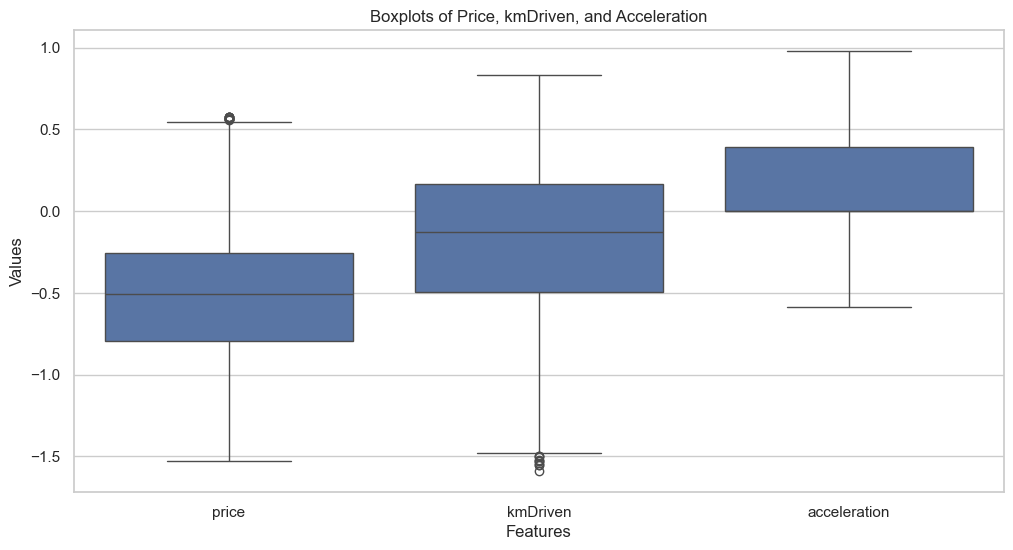

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot for 'price', 'kmDriven', and 'acceleration'
plt.figure(figsize=(12, 6))

# Plot boxplots for the selected features
sns.boxplot(x='variable', y='value', data=pd.melt(final_dataframe[['price', 'kmDriven', 'acceleration']], var_name='variable'))

# Set plot labels and title
plt.title('Boxplots of Price, kmDriven, and Acceleration')
plt.xlabel('Features')
plt.ylabel('Values')

# Show the plot
plt.show()


In [52]:
#since, there is still more outliers in price and kmDriven, we can remove it

In [53]:
import pandas as pd

# Define a function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)  # 25th percentile
        Q3 = df[column].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile Range

        # Define the upper and lower bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers (values outside the bounds)
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

# List of columns for which we want to remove outliers
columns_to_check = ['price', 'kmDriven', 'acceleration']

# Apply the IQR outlier removal
final_dataframe = remove_outliers_iqr(final_dataframe, columns_to_check)

# Display the modified DataFrame info after removing outliers
print(final_dataframe.info())


<class 'pandas.core.frame.DataFrame'>
Index: 4504 entries, 0 to 8367
Columns: 1890 entries, modelYear to ground_clearance_unladen_91
dtypes: bool(1863), float64(23), int32(3), object(1)
memory usage: 8.9+ MB
None


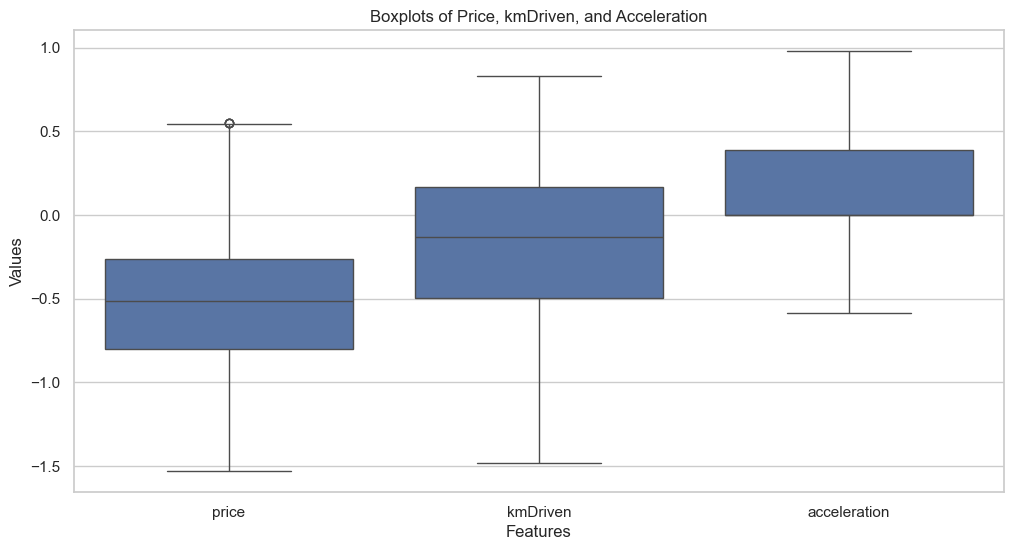

In [54]:
# Create a boxplot for 'price', 'kmDriven', and 'acceleration'
plt.figure(figsize=(12, 6))

# Plot boxplots for the selected features
sns.boxplot(x='variable', y='value', data=pd.melt(final_dataframe[['price', 'kmDriven', 'acceleration']], var_name='variable'))

# Set plot labels and title
plt.title('Boxplots of Price, kmDriven, and Acceleration')
plt.xlabel('Features')
plt.ylabel('Values')

# Show the plot
plt.show()


In [55]:
#Given that features such as kerb_weight and cargo_volumn show low variance, dropping it from the dataset. 
#Removing them can simplify our model and reduce computational complexity.

In [56]:
# Step 1: Convert all columns to numeric, coercing errors (non-numeric values) to NaN
final_dataframe = final_dataframe.apply(pd.to_numeric, errors='coerce')

# Step 2: Compute variance only on numeric columns
variance = final_dataframe.var()

# Step 3: Set a threshold to drop features with low variance
threshold = 0.01  # You can adjust this value if needed

# Step 4: Drop features with low variance
final_dataframe = final_dataframe.loc[:, variance > threshold]

# Verify the remaining columns after removing low-variance features
print(f"Remaining columns after removing low-variance features: {final_dataframe.columns}")


Remaining columns after removing low-variance features: Index(['modelYear', 'kmDriven', 'ownerNo', 'price', 'registration_year',
       'year_of_manufacture', 'displacement', 'no_of_cylinder', 'length',
       'width',
       ...
       'rear_brake_type_Drum', 'rear_brake_type_Solid Disc',
       'tyre_type_Radial, Tubeless', 'tyre_type_Tubeless',
       'tyre_type_Tubeless Tyres', 'tyre_type_Tubeless Tyres, Radial',
       'tyre_type_Tubeless, Radial', 'tyre_type_Tubeless,Radial',
       'ground_clearance_unladen_160', 'ground_clearance_unladen_190'],
      dtype='object', length=178)


In [57]:
#we can check how features like kmDriven, modelYear, and displacement relate to the price of the car using scatterplot.

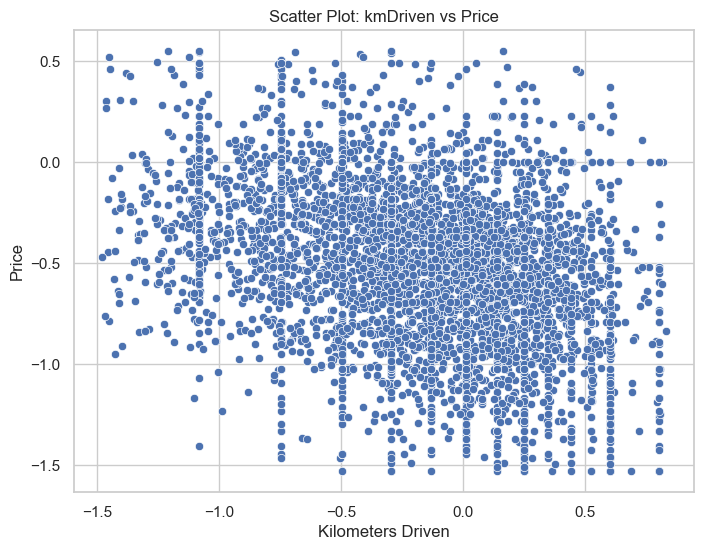

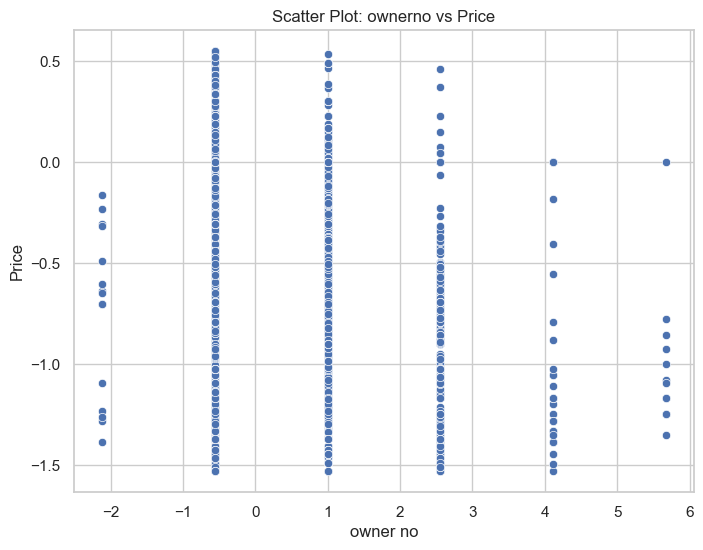

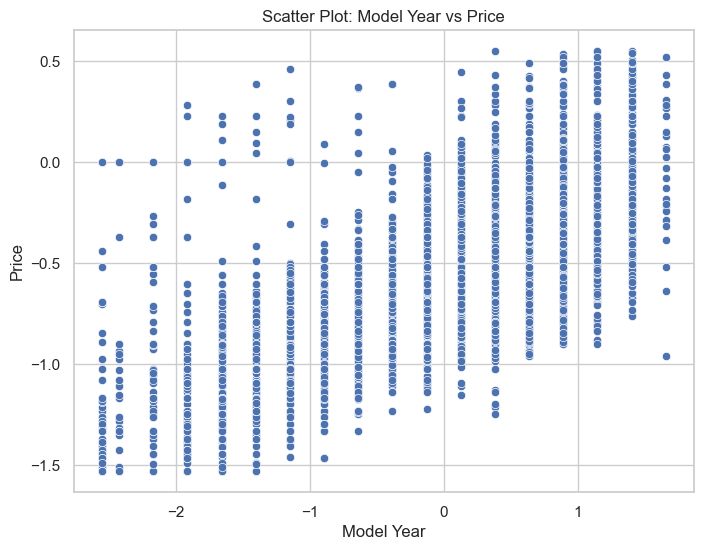

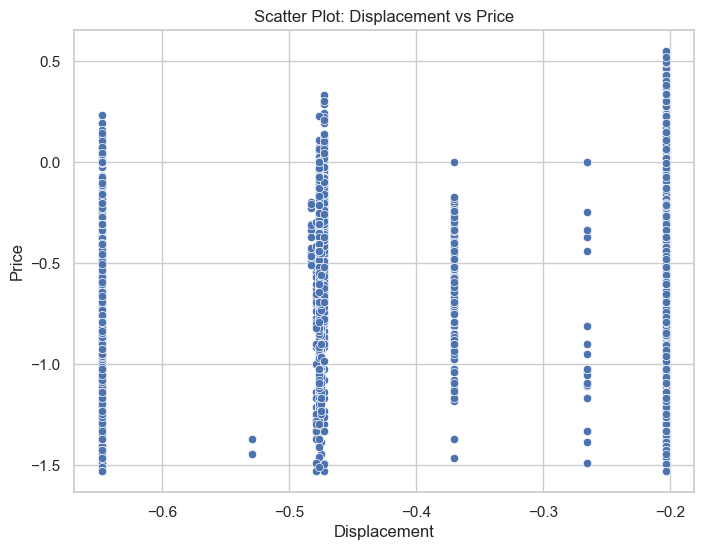

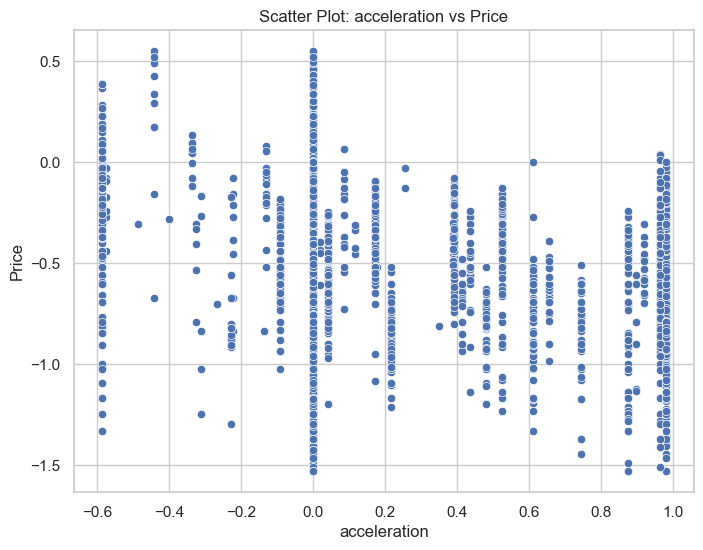

In [58]:
# Scatter plot for kmDriven vs Price
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_dataframe, x='kmDriven', y='price')
plt.title('Scatter Plot: kmDriven vs Price')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price')
plt.show()

# Scatter plot for ownerNo vs Price
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_dataframe, x='ownerNo', y='price')
plt.title('Scatter Plot: ownerno vs Price')
plt.xlabel('owner no')
plt.ylabel('Price')
plt.show()

# Scatter plot for modelYear vs Price
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_dataframe, x='modelYear', y='price')
plt.title('Scatter Plot: Model Year vs Price')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.show()

# Scatter plot for displacement vs Price
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_dataframe, x='displacement', y='price')
plt.title('Scatter Plot: Displacement vs Price')
plt.xlabel('Displacement')
plt.ylabel('Price')
plt.show()


# Scatter plot for acceleration vs Price
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_dataframe, x='acceleration', y='price')
plt.title('Scatter Plot: acceleration vs Price')
plt.xlabel('acceleration')
plt.ylabel('Price')
plt.show()



In [59]:
#We can plot the distribution of price, kmDriven, and other features to understand their spread.

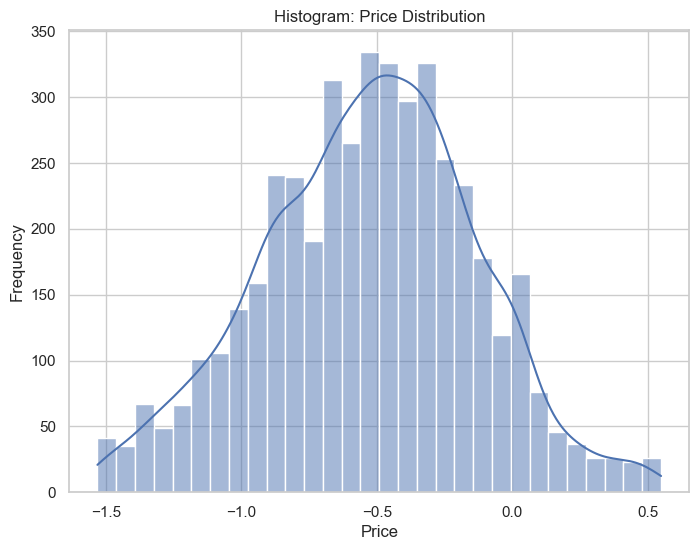

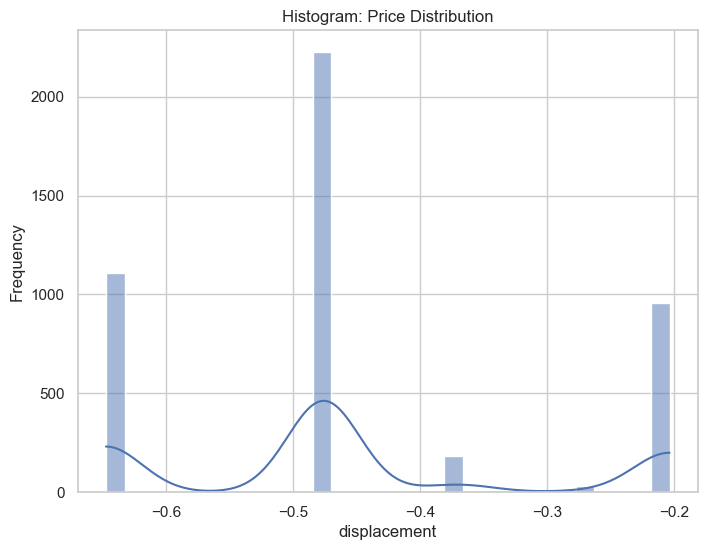

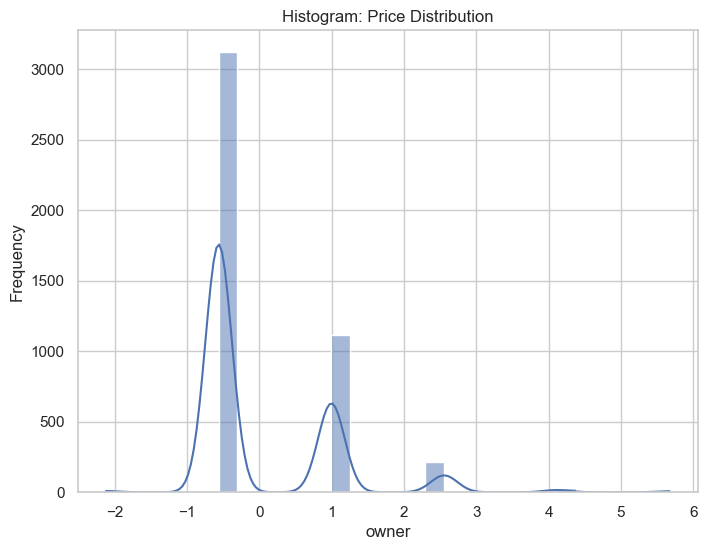

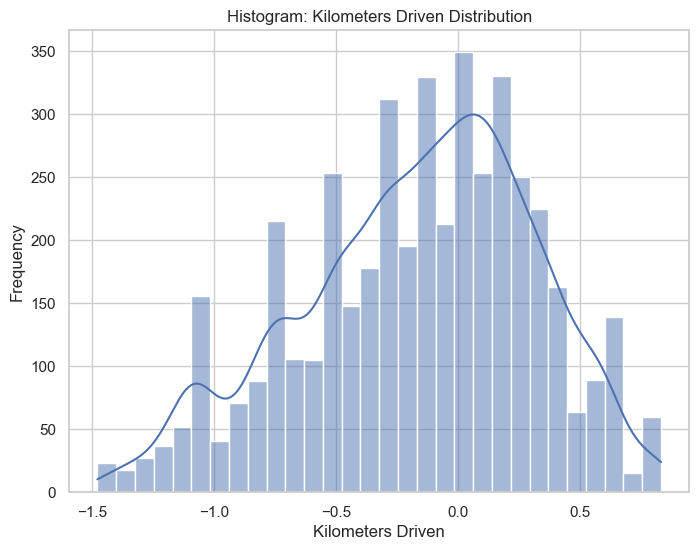

In [60]:
# Histogram for Price
plt.figure(figsize=(8, 6))
sns.histplot(final_dataframe['price'], kde=True, bins=30)
plt.title('Histogram: Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(final_dataframe['displacement'], kde=True, bins=30)
plt.title('Histogram: Price Distribution')
plt.xlabel('displacement')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(final_dataframe['ownerNo'], kde=True, bins=30)
plt.title('Histogram: Price Distribution')
plt.xlabel('owner')
plt.ylabel('Frequency')
plt.show()

# Histogram for kmDriven
plt.figure(figsize=(8, 6))
sns.histplot(final_dataframe['kmDriven'], kde=True, bins=30)
plt.title('Histogram: Kilometers Driven Distribution')
plt.xlabel('Kilometers Driven')
plt.ylabel('Frequency')
plt.show()


In [61]:
##heatmap

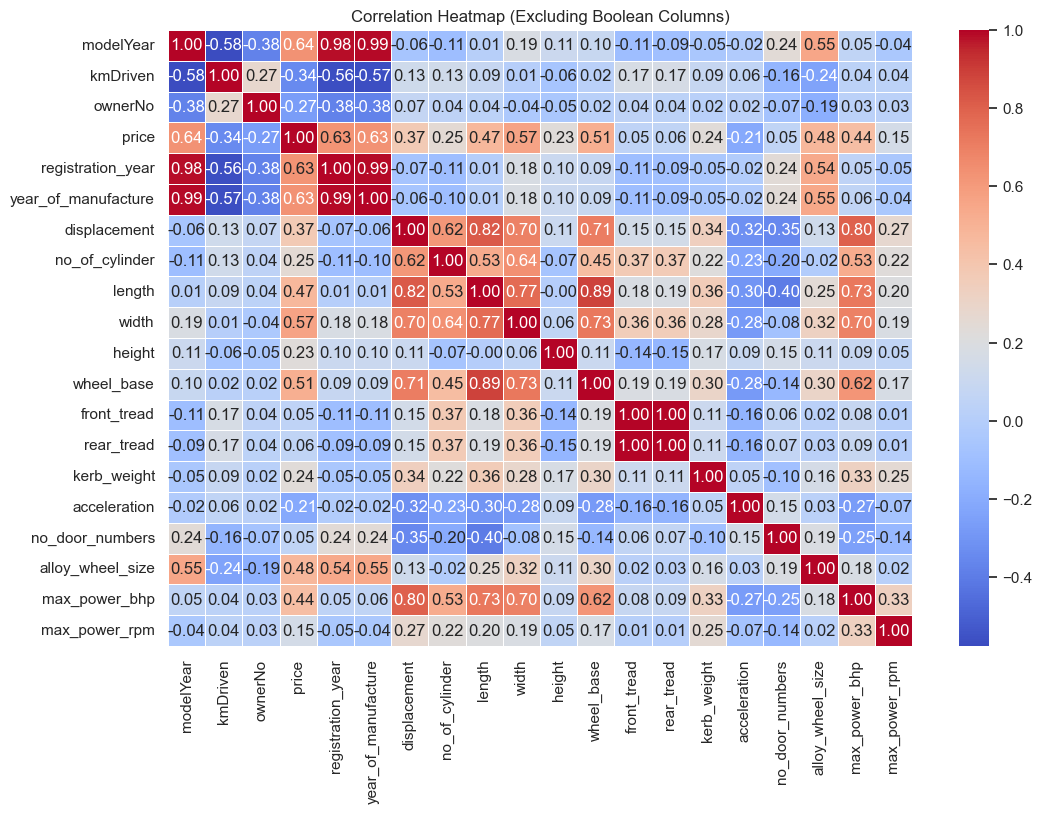

In [62]:
# Select only the numerical columns (excluding boolean columns)
numerical_columns = final_dataframe.select_dtypes(include=['float64', 'int32']).columns

# Compute the correlation matrix for numerical columns only
correlation_matrix = final_dataframe[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (Excluding Boolean Columns)')
plt.show()


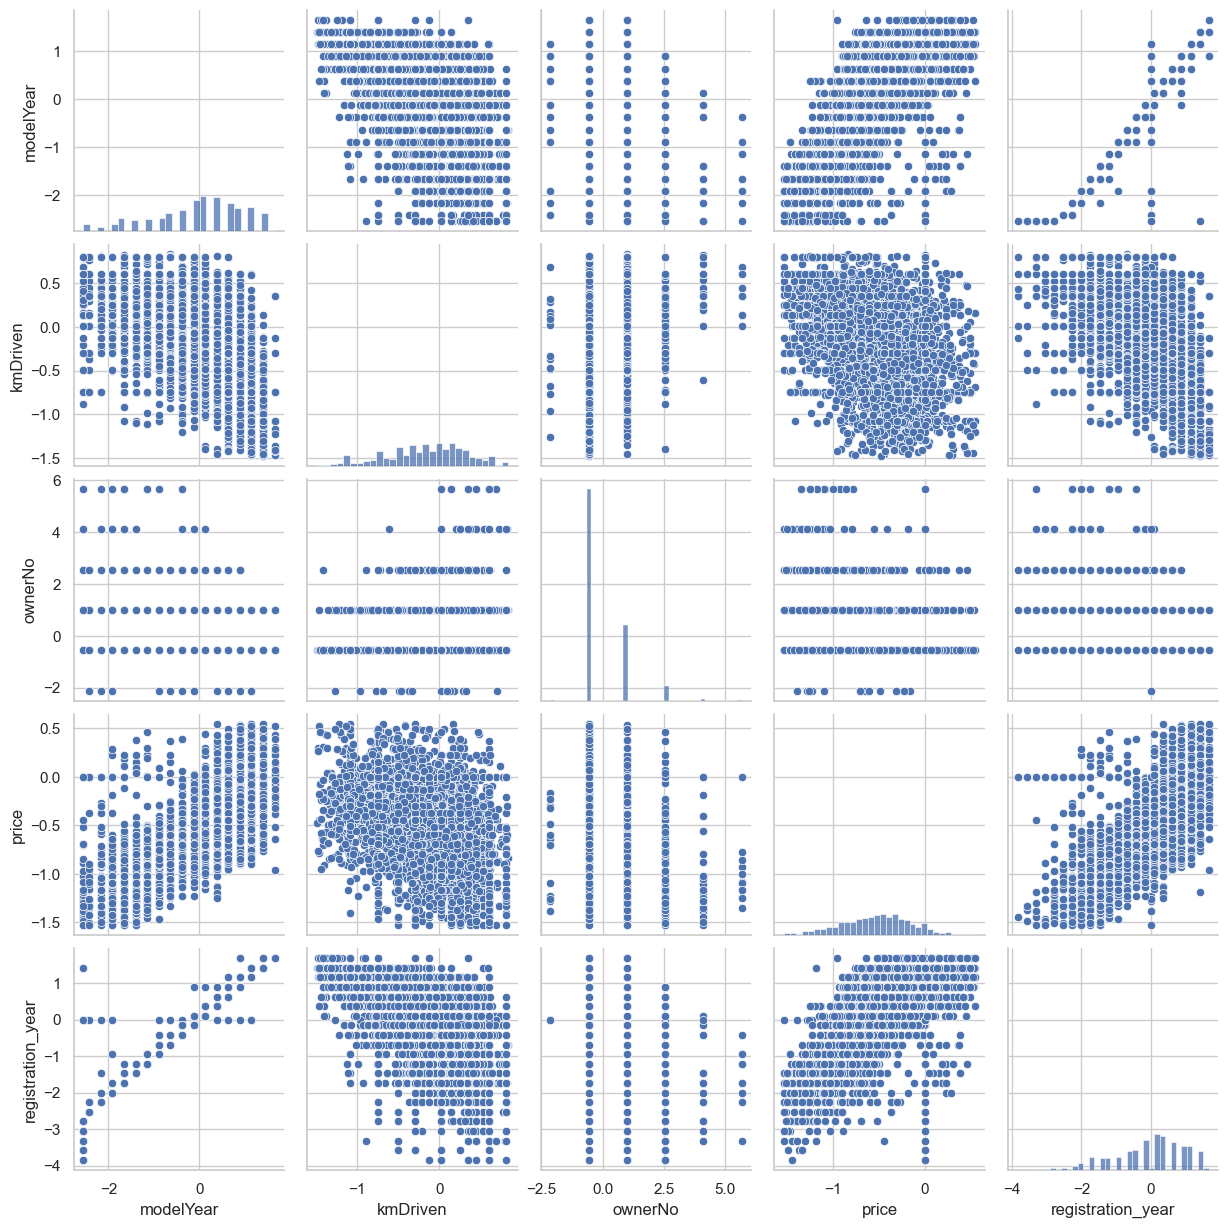

In [63]:
sns.pairplot(final_dataframe[numerical_columns[:5]])  # Visualize pairwise relationships for 5 selected columns
plt.show()


In [64]:
# Select numerical features
numerical_columns = final_dataframe.select_dtypes(include=['float64', 'int32']).columns

# Compute correlation matrix
correlation_matrix = final_dataframe[numerical_columns].corr()

# Focus on correlation with 'car_price' (adjust column name as per your dataset)
car_price_corr = correlation_matrix['price'].sort_values(ascending=False)

# Print the correlations
print(car_price_corr)


price                  1.000000
modelYear              0.635094
year_of_manufacture    0.631323
registration_year      0.625354
width                  0.567842
wheel_base             0.514408
alloy_wheel_size       0.477997
length                 0.470591
max_power_bhp          0.444416
displacement           0.373762
no_of_cylinder         0.254920
kerb_weight            0.236463
height                 0.228372
max_power_rpm          0.152814
rear_tread             0.057750
no_door_numbers        0.052231
front_tread            0.049860
acceleration          -0.207105
ownerNo               -0.265891
kmDriven              -0.343930
Name: price, dtype: float64


                          Feature  Importance
4             year_of_manufacture    0.335433
8                           width    0.225050
7                          length    0.077810
0                       modelYear    0.047724
3               registration_year    0.045834
..                            ...         ...
46             model_Renault KWID    0.000012
133         engine_type_k14B VVT     0.000008
42          model_Maruti S-Presso    0.000005
28   model_Hyundai Grand i10 Nios    0.000004
19            model_Datsun RediGO    0.000003

[177 rows x 2 columns]


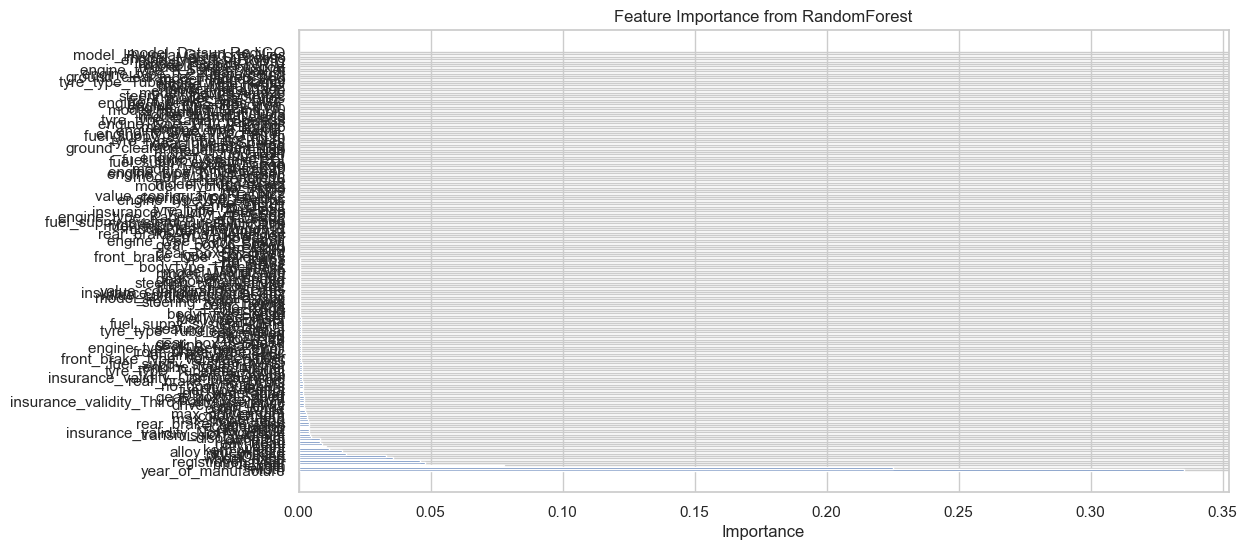

In [65]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Prepare your data
# Assuming 'final_dataframe' is your dataframe, and 'price' is the target variable
X = final_dataframe.drop(columns=['price'])  # All features except 'price'
y = final_dataframe['price']  # Target variable: 'price'

# Initialize and train a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from RandomForest')
plt.show()


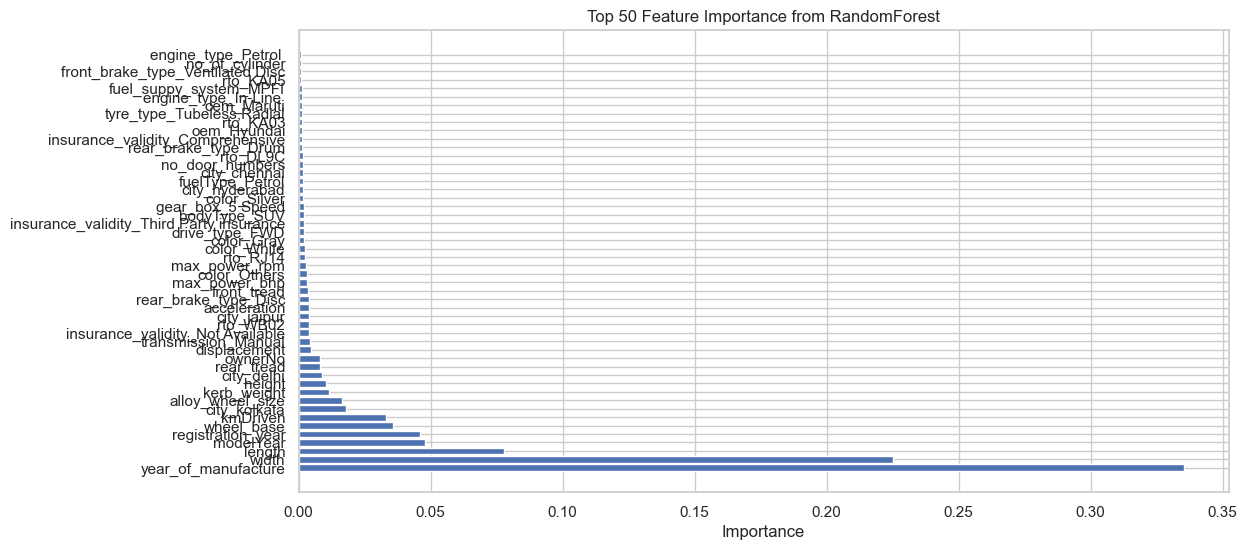

In [66]:
# Number of top features to plot
top_n = 50

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top N features
top_features = feature_importance_df.head(top_n)

# Plot the top N important features
plt.figure(figsize=(12, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importance from RandomForest')
plt.show()

In [67]:
top_features = feature_importance_df.head(top_n)
print(top_features)

                                      Feature  Importance
4                         year_of_manufacture    0.335433
8                                       width    0.225050
7                                      length    0.077810
0                                   modelYear    0.047724
3                           registration_year    0.045834
10                                 wheel_base    0.035849
1                                    kmDriven    0.032937
69                               city_kolkata    0.017936
16                           alloy_wheel_size    0.016558
13                                kerb_weight    0.011577
9                                      height    0.010285
66                                 city_delhi    0.008953
12                                 rear_tread    0.008016
2                                     ownerNo    0.007978
5                                displacement    0.004887
64                        transmission_Manual    0.004509
71           i

## MODEL CREATION

In [69]:
from sklearn.model_selection import train_test_split
# Extract the top 50 feature names from the 'Feature' column of the top_features DataFrame
top_n_features = top_features['Feature'].tolist()

# Create a new dataframe with only the selected top 50 features
X_top_50 = final_dataframe[top_n_features]  # Only select top 50 features
y = final_dataframe['price']  # Target variable: 'price'

# Now, perform the train-test split with these top 50 features
X_train, X_test, y_train, y_test = train_test_split(X_top_50, y, test_size=0.2, random_state=42)

In [70]:
# Importing necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [71]:
# Initialize the models
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# Perform 5-fold cross-validation for each model
lr_cv_score = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
dt_cv_score = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
rf_cv_score = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
gb_cv_score = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

# Print the mean cross-validation score for each model
print(f"Linear Regression CV Score: {-lr_cv_score}")
print(f"Decision Tree CV Score: {-dt_cv_score}")
print(f"Random Forest CV Score: {-rf_cv_score}")
print(f"Gradient Boosting CV Score: {-gb_cv_score}")


Linear Regression CV Score: 0.041998737761049065
Decision Tree CV Score: 0.05515509896492958
Random Forest CV Score: 0.03055695954051097
Gradient Boosting CV Score: 0.030351712076720966


In [72]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Perform GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

# Best parameters for Random Forest
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")


Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [73]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Perform GridSearchCV for Gradient Boosting
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)

# Best parameters for Gradient Boosting
print(f"Best parameters for Gradient Boosting: {grid_search_gb.best_params_}")


Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [74]:
# Define the parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Perform GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search_dt.fit(X_train, y_train)

# Best parameters for Decision Tree
print(f"Best parameters for Decision Tree: {grid_search_dt.best_params_}")


Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions using the tuned models

# For Random Forest (using best parameters from GridSearchCV)
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# For Gradient Boosting (using best parameters from GridSearchCV)
best_gb_model = grid_search_gb.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)

# For Decision Tree (using best parameters from GridSearchCV)
best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)

# For Linear Regression
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Compute evaluation metrics
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

# Evaluate each model
mae_lr, mse_lr, rmse_lr, r2_lr = evaluate_model(y_test, y_pred_lr)
mae_dt, mse_dt, rmse_dt, r2_dt = evaluate_model(y_test, y_pred_dt)
mae_rf, mse_rf, rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)
mae_gb, mse_gb, rmse_gb, r2_gb = evaluate_model(y_test, y_pred_gb)

# Print performance metrics
print(f"\nLinear Regression Performance:")
print(f"MAE: {mae_lr}, MSE: {mse_lr}, RMSE: {rmse_lr}, R2: {r2_lr}")

print(f"\nDecision Tree Performance:")
print(f"MAE: {mae_dt}, MSE: {mse_dt}, RMSE: {rmse_dt}, R2: {r2_dt}")

print(f"\nRandom Forest Performance:")
print(f"MAE: {mae_rf}, MSE: {mse_rf}, RMSE: {rmse_rf}, R2: {r2_rf}")

print(f"\nGradient Boosting Performance:")
print(f"MAE: {mae_gb}, MSE: {mse_gb}, RMSE: {rmse_gb}, R2: {r2_gb}")



Linear Regression Performance:
MAE: 0.12337337756192089, MSE: 0.042360244089191125, RMSE: 0.20581604429487785, R2: 0.7461457603077178

Decision Tree Performance:
MAE: 0.12200904146941949, MSE: 0.0414852255621867, RMSE: 0.2036792222151948, R2: 0.7513895252497156

Random Forest Performance:
MAE: 0.09909022168710238, MSE: 0.030488838534621313, RMSE: 0.17461053385927583, R2: 0.8172880942562378

Gradient Boosting Performance:
MAE: 0.10463417836391531, MSE: 0.03221555263840984, RMSE: 0.17948691495039365, R2: 0.8069403329199186


C:\Users\vanat\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\vanat\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\vanat\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\vanat\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

In [76]:
##The Random Forest model is the best performer, with the lowest MAE (0.0991), MSE (0.0305), and RMSE (0.1746), alongside the highest R² (0.8173). 
#This indicates it has the most accurate and reliable predictions with the least error, while also explaining the greatest proportion of variance in the target variable compared to the other models.

## OPTIMIZATION

In [78]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# 1. Car Age: Derived from the year of manufacture
X_top_50['car_age'] = 2024 - X_top_50['year_of_manufacture']

# 2. Car Volume: Calculated as the product of width, length, and height
X_top_50['car_volume'] = X_top_50['width'] * X_top_50['length'] * X_top_50['height']

# 3. Fuel Efficiency: Based on kmDriven and displacement
X_top_50['fuel_efficiency'] = X_top_50['kmDriven'] / X_top_50['displacement']

# Step 2: Polynomial Features (degree=2 for interaction and non-linear relationships)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_top_50)

# Step 3: Train-Test Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Step 4: Model Training with Regularization
# Initialize models
lr_model = LinearRegression()
lasso_model = Lasso(alpha=0.1)  # Lasso (L1 Regularization)
ridge_model = Ridge(alpha=0.1)  # Ridge (L2 Regularization)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train models
lr_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Step 5: Model Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Step 6: Model Evaluation
# Define evaluation function
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

# Evaluate models
mae_lr, mse_lr, rmse_lr, r2_lr = evaluate_model(y_test, y_pred_lr)
mae_lasso, mse_lasso, rmse_lasso, r2_lasso = evaluate_model(y_test, y_pred_lasso)
mae_ridge, mse_ridge, rmse_ridge, r2_ridge = evaluate_model(y_test, y_pred_ridge)
mae_rf, mse_rf, rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)

# Step 7: Print Evaluation Metrics
print(f"Linear Regression Performance: MAE: {mae_lr}, MSE: {mse_lr}, RMSE: {rmse_lr}, R2: {r2_lr}")
print(f"Lasso Regularized Performance: MAE: {mae_lasso}, MSE: {mse_lasso}, RMSE: {rmse_lasso}, R2: {r2_lasso}")
print(f"Ridge Regularized Performance: MAE: {mae_ridge}, MSE: {mse_ridge}, RMSE: {rmse_ridge}, R2: {r2_ridge}")
print(f"Random Forest Performance: MAE: {mae_rf}, MSE: {mse_rf}, RMSE: {rmse_rf}, R2: {r2_rf}")


C:\Users\vanat\AppData\Local\Temp\ipykernel_5336\3479040441.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_top_50['car_age'] = 2024 - X_top_50['year_of_manufacture']
C:\Users\vanat\AppData\Local\Temp\ipykernel_5336\3479040441.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_top_50['car_volume'] = X_top_50['width'] * X_top_50['length'] * X_top_50['height']
C:\Users\vanat\AppData\Local\Temp\ipykernel_5336\3479040441.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

Linear Regression Performance: MAE: 0.31096209954337584, MSE: 7.704224161428584, RMSE: 2.775648421797794, R2: -45.169468778330376
Lasso Regularized Performance: MAE: 0.12004379358851772, MSE: 0.040551262107014784, RMSE: 0.2013734394278818, R2: 0.756986532252646
Ridge Regularized Performance: MAE: 0.13017239695382976, MSE: 0.09001692094103128, RMSE: 0.3000282002429626, R2: 0.460551337314966
Random Forest Performance: MAE: 0.09907705320614241, MSE: 0.030022182996130627, RMSE: 0.17326910571746662, R2: 0.8200846429888731


C:\Users\vanat\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\vanat\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\vanat\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\vanat\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

## Save the model

In [157]:
import pickle

# Save the best Random Forest model using pickle
with open('best_random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_rf_model, file)

print("Best Random Forest model saved as 'best_random_forest_model.pkl'")


Best Random Forest model saved as 'best_random_forest_model.pkl'
